## Cell typing by data integration and by classification

Here, we walk you through three ways to predict the cell types in your *query* scRNAseq data set by leveraging another, well-anntated *reference* dataset. The first way is to directly combine the datasets an cluster them together. The second way is called 'Batch Balanced KNN', which works by finding kNN across batches. The third way is to classify the query data with classifier that was trained with the reference data. 

### Data

We will use mouse cells from gastrula-stage embryos from two studies.

The reference data comes from [Pijuan-Sala et al 2019](https://pubmed.ncbi.nlm.nih.gov/30787436/) which describes a single cell census of gastrulation in mouse (E6.5 to E8.5). You can download [the .h5ad file here](https://jhu.instructure.com/files/13371890/download?download_frd=1).

The query data comes from another gastula census [Grosswendt et al 2020](https://pubmed.ncbi.nlm.nih.gov/32728215/). You can download [the .h5ad file here](https://jhu.instructure.com/files/13371891/download?download_frd=1).

For the sake of computational efficiency, we have taken only a small subset of the cells from each of these studies. The cell type label is stored in `.obs['celltype']`

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import pySingleCellNet as cn

In [2]:
adPijuan = sc.read_h5ad("ad_Pijuan_demo.h5ad")
adPijuan

AnnData object with n_obs × n_vars = 2071 × 21133
    obs: 'cell', 'stage', 'celltype'
    var: 'ENSEMBL'

In [3]:
adPijuan.obs['celltype'].value_counts()

celltype
Meso.Cardio     300
PGC             297
Endo.Gut        296
Epiblast        296
Anterior.PS     294
Ecto.Neural     294
Meso.Nascent    294
Name: count, dtype: int64

In [4]:
adTrain = adPijuan
adTrain.layers['counts'] = adTrain.X.copy()
sc.pp.normalize_total(adTrain)
sc.pp.log1p(adTrain)
sc.pp.highly_variable_genes(adTrain, n_top_genes=2000, flavor='seurat_v3', layer='counts')

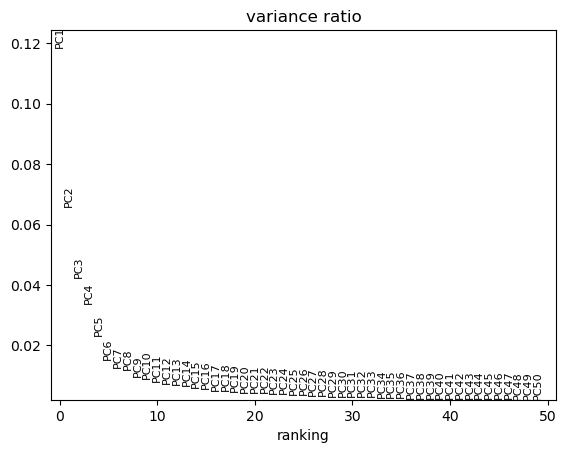

In [5]:
sc.tl.pca(adTrain, mask_var='highly_variable')
sc.pl.pca_variance_ratio(adTrain, n_pcs=50)

In [6]:
def_npcs = 20
def_nneigh = 10
sc.pp.neighbors(adTrain, n_neighbors = def_nneigh,  n_pcs = def_npcs)

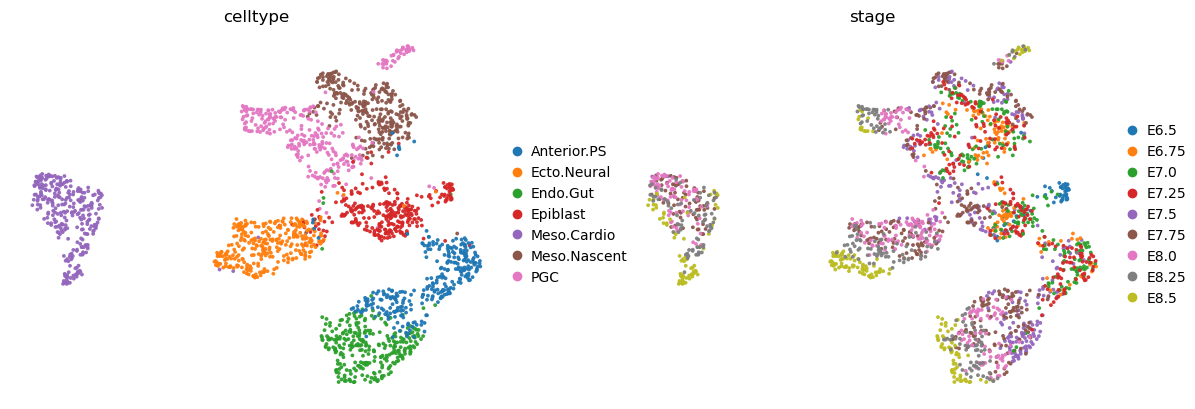

In [7]:
sc.tl.umap(adTrain)
sc.pl.umap(adTrain, color=['celltype', 'stage'], size=30, alpha=.95,frameon=False)

### Naive concatenation of anndata objects, then clustering

In [8]:
adGross = sc.read_h5ad("ad_Grosswendt_demo.h5ad")
adGross

AnnData object with n_obs × n_vars = 700 × 21133
    obs: 'embryo', 'stage', 'celltype'
    var: 'name'

In [9]:
adPijuan = sc.read_h5ad("ad_Pijuan_demo.h5ad")
adPijuan.obs['study'] = 'Pijuan'
adGross.obs['study'] = 'Grosswendt'

In [10]:
import anndata as ad
del(adPijuan.raw)
adComb = ad.concat([adPijuan, adGross])

In [11]:
adComb.obs['study'].value_counts()

study
Pijuan        2071
Grosswendt     700
Name: count, dtype: int64

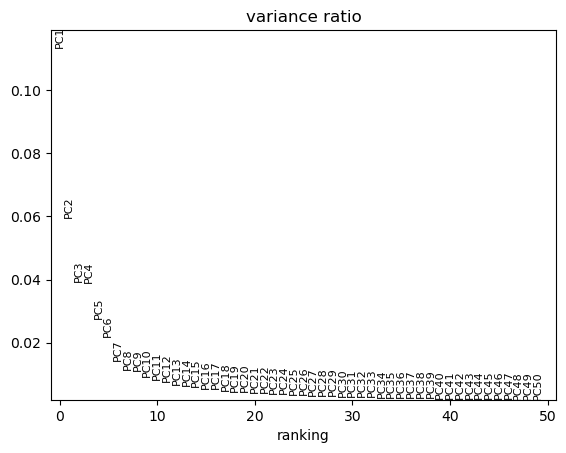

In [12]:
adComb.layers['counts'] = adComb.X.copy()
sc.pp.normalize_total(adComb)
sc.pp.log1p(adComb)
sc.pp.highly_variable_genes(adComb, n_top_genes=2000, flavor='seurat_v3', layer='counts')
sc.tl.pca(adComb, mask_var='highly_variable')
sc.pl.pca_variance_ratio(adComb, n_pcs=50)

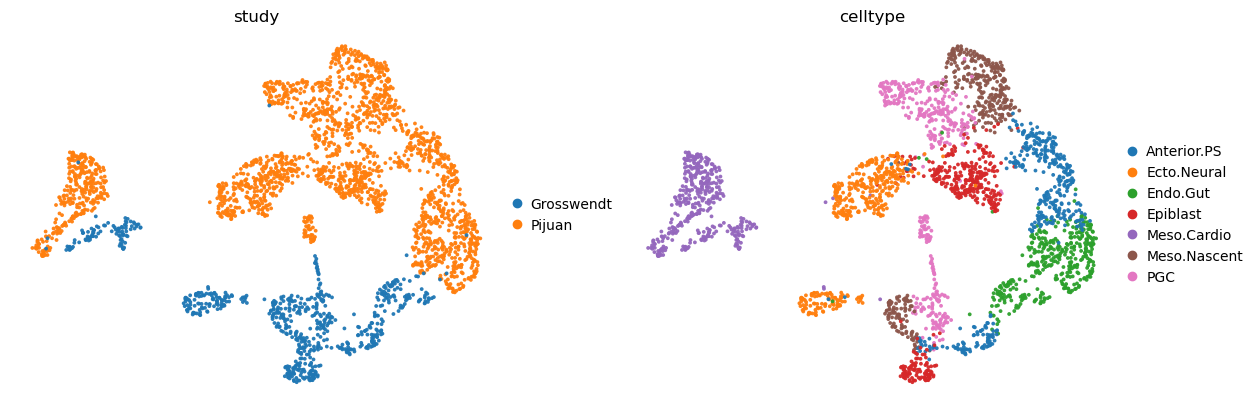

In [13]:
def_npcs = 20
def_nneigh = 10 # preference -- allows detection of rare populations
sc.pp.neighbors(adComb, n_neighbors = def_nneigh,  n_pcs = def_npcs)
sc.tl.umap(adComb)
sc.pl.umap(adComb, color=['study', 'celltype'], size=30, alpha=.95,frameon=False)

The embedding above strongly suggests that there will be very little clustering of cells from the same type across data from the two studies.

### Method 2: BBKNN

For details on how the `sc.external.pp.bbknn()` function works, go to [scanpy's documentation](https://scanpy.readthedocs.io/en/stable/generated/scanpy.external.pp.bbknn.html). 

Also see the section on [graph based integration in the online best practices book](https://www.sc-best-practices.org/cellular_structure/integration.html#graph-based-integration)


In [14]:
adComb2 = ad.concat([adPijuan, adGross])
batch_key = "study"

sc.pp.filter_genes(adComb2, min_cells=3)
adComb2.layers['counts'] = adComb2.X.copy()

In [15]:
sc.pp.normalize_total(adComb2)
sc.pp.log1p(adComb2)
sc.pp.highly_variable_genes(adComb2, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key)

In [17]:
adata_hvg = adComb2[:,adComb2.var["highly_variable"]].copy()
sc.pp.pca(adata_hvg)
sc.external.pp.bbknn(adata_hvg, batch_key=batch_key)

In [18]:
adata_hvg

AnnData object with n_obs × n_vars = 2771 × 2000
    obs: 'stage', 'celltype', 'study'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

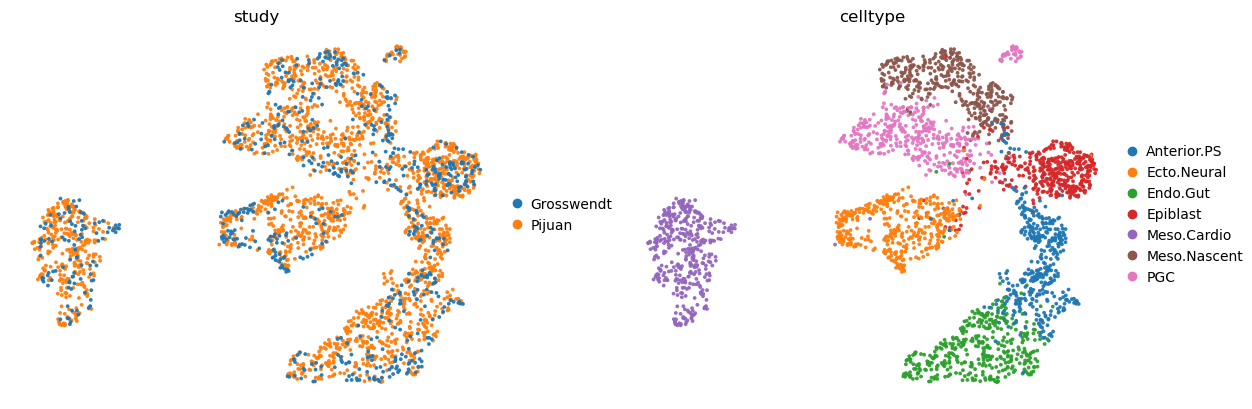

In [19]:
sc.tl.umap(adata_hvg)
sc.pl.umap(adata_hvg, color=['study', 'celltype'], size=30, alpha=.95,frameon=False)

The integration by BBKNN in this example looks pretty good! Note that in both this approach and the naive integration, the user would still need to perform some post-integration processing in order to label the query cells. This could easily be done by clustering and then assotating query cells based on the most frequent label of reference cells sharing the same cluster as query cells. Try to think of other approaches to this task.

### Method 3: ML Classification

In the third approach, we will directly annotate query cells by classifying them using a model trained on reference data. Our [PySingleCellNet (pySCN) package](https://pysinglecellnet.readthedocs.io/) was designed for this task.

In [20]:
adRef2 = sc.read_h5ad("ad_Pijuan_demo.h5ad")
adQuery = sc.read_h5ad("ad_Grosswendt_demo.h5ad")

In [21]:
cn.ut.limit_anndata_to_common_genes([adRef2, adQuery])

In [22]:
n_cells = 100
groupby = 'celltype'
# explain
strata_col = 'stage'

tids, vids = cn.ut.split_adata_indices(adRef2, n_cells, groupby=groupby, cellid=None, strata_col=strata_col)

In [23]:
adTrain = adRef2[tids].copy()
adHO = adRef2[vids].copy()

In [24]:
sc.pp.highly_variable_genes(adTrain, n_top_genes=3000, flavor='seurat_v3')
sc.pp.normalize_total(adTrain)
sc.pp.log1p(adTrain)

In [25]:
n_rand = n_cells
nTopGenes = 30
nTopGenePairs = 40
n_comps = 30
n_trees = 1000
obs_pred = "SCN_class_argmax"

clf = cn.cl.train_classifier(adTrain, groupby, nRand = n_rand, nTopGenes = nTopGenes, nTopGenePairs = nTopGenePairs, n_comps = n_comps)

Training classifier |████████████████████████████████████████| 5/5 [100%] in 1.9s (2.59/s) 


In [26]:
cn.cl.classify_anndata(adHO, clf)

In [27]:
adHO
# cn.pl.heatmap_scores(adHO, groubpy='SCN_class_argmax')

AnnData object with n_obs × n_vars = 1386 × 21133
    obs: 'cell', 'stage', 'celltype', 'cellid', 'SCN_class_argmax'
    var: 'ENSEMBL'
    uns: 'SCN_class_argmax_colors'
    obsm: 'SCN_score'

In [28]:
type(adHO.obsm)

anndata._core.aligned_mapping.AxisArrays

In [29]:
adHO.obsm

AxisArrays with keys: SCN_score

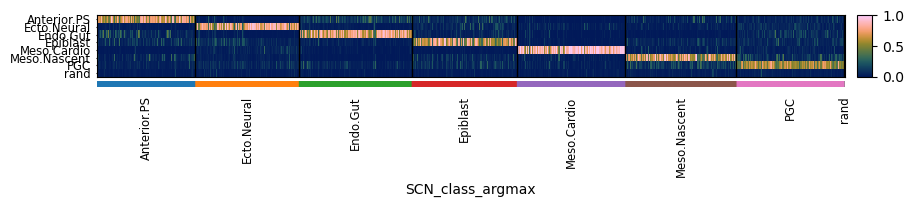

In [30]:
cn.pl.heatmap_scores(adHO, groupby = 'SCN_class_argmax')

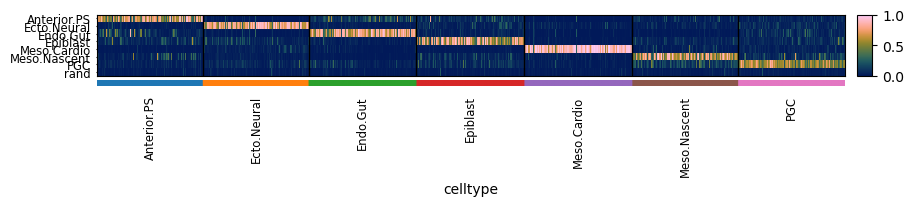

In [31]:
cn.pl.heatmap_scores(adHO, groupby = 'celltype')

In [32]:
c_report = cn.cl.create_classifier_report(adHO, ground_truth=groupby, prediction=obs_pred)

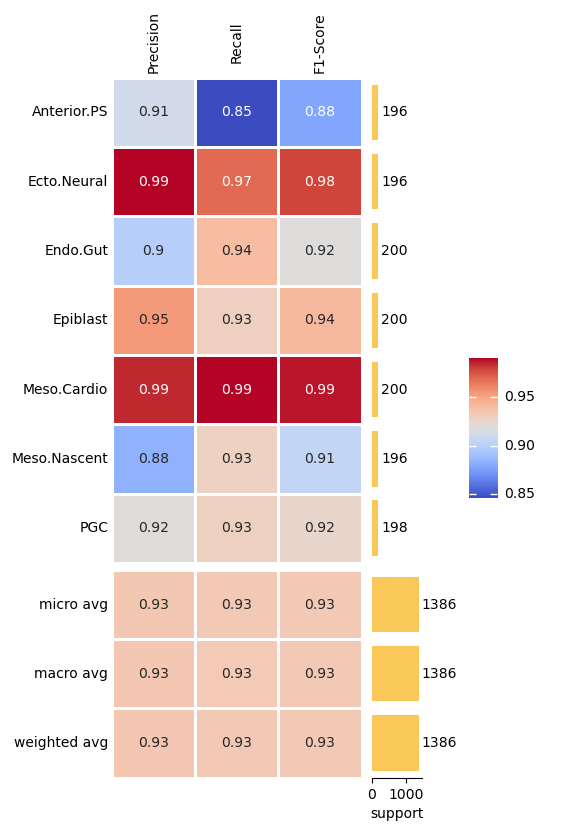

In [33]:
cn.pl.heatmap_classifier_report(c_report)

In [34]:
cn.cl.classify_anndata(adQuery, clf)

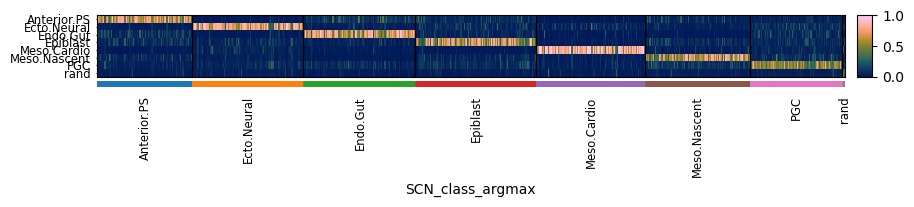

In [35]:
cn.pl.heatmap_scores(adQuery, groupby = 'SCN_class_argmax')

In [36]:
adQuery.obs['SCN_class_argmax'].value_counts()

SCN_class_argmax
Epiblast        113
Endo.Gut        105
Ecto.Neural     104
Meso.Cardio     102
Meso.Nascent     98
Anterior.PS      89
PGC              87
rand              2
Name: count, dtype: int64

In [37]:
c_report_2 = cn.cl.create_classifier_report(adQuery, ground_truth=groupby, prediction=obs_pred)

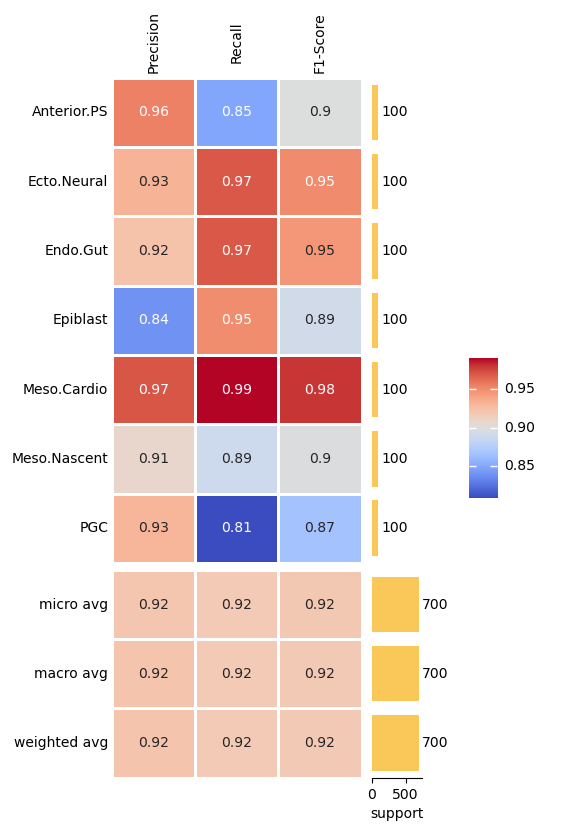

In [38]:
cn.pl.heatmap_classifier_report(c_report_2)

In [39]:
tThrs_val_05_HO = cn.cl.comp_ct_thresh(adHO, 0.05)

In [40]:
tThrs_val_05_HO

0
Anterior.PS   0.36695
Ecto.Neural   0.39885
Endo.Gut      0.38820
Epiblast      0.31290
Meso.Cardio   0.56400
Meso.Nascent  0.32700
PGC           0.35690

In [41]:
rela_graph = cn.cl.paga_connectivities_to_igraph(adTrain, threshold = 0.3, n_comps = n_comps, group_key = groupby)

In [42]:
cn.cl.categorize_classification(adQuery, tThrs_val_05_HO, rela_graph)

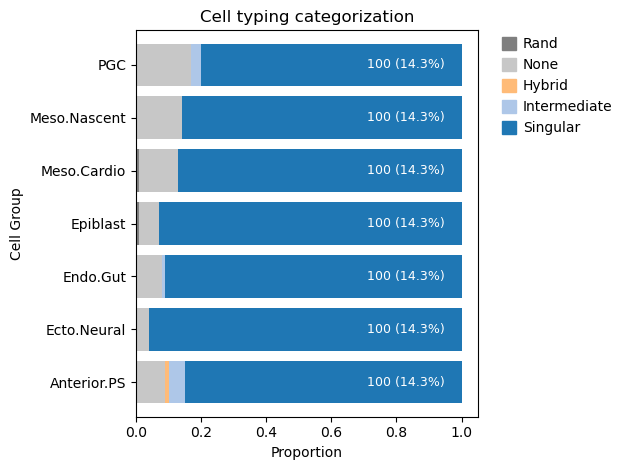

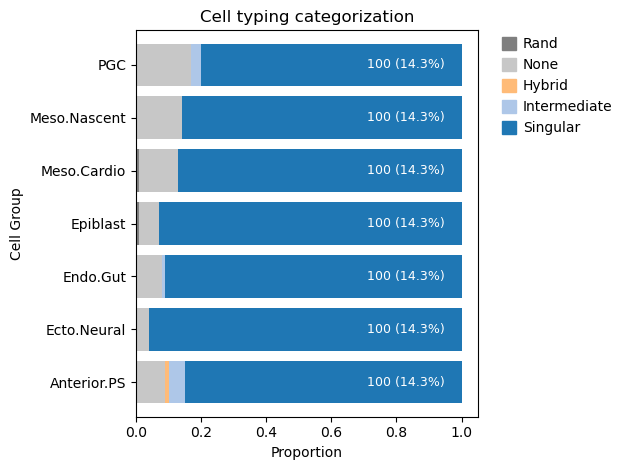

In [44]:
cn.pl.stackedbar_categories(adQuery, class_col_name='celltype', show_pct_total=True)

In [45]:
adQuery

AnnData object with n_obs × n_vars = 700 × 21133
    obs: 'embryo', 'stage', 'celltype', 'SCN_class_argmax', 'SCN_class_emp', 'SCN_class_type', 'SCN_class_cat'
    var: 'name'
    uns: 'SCN_class_argmax_colors'
    obsm: 'SCN_score'

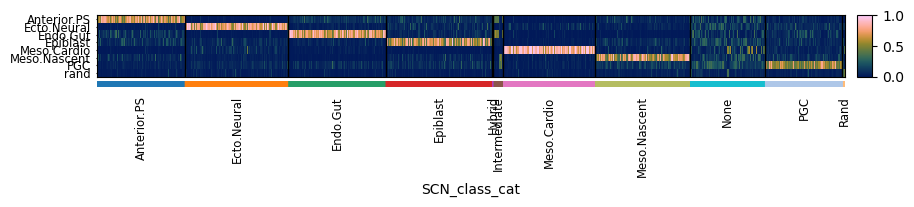

In [46]:
cn.pl.heatmap_scores(adQuery, groupby = 'SCN_class_cat')

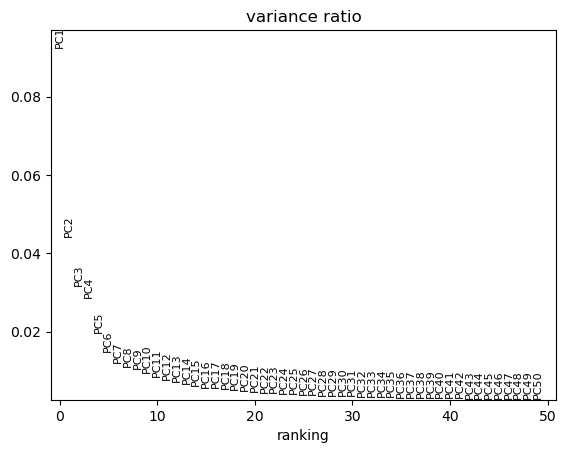

In [47]:
adtest2 = adQuery.copy()
adtest2.layers['counts'] = adtest2.X.copy()
sc.pp.normalize_total(adtest2)
sc.pp.log1p(adtest2)
sc.pp.highly_variable_genes(adtest2, n_top_genes=3000, flavor='seurat_v3', layer='counts')
sc.tl.pca(adtest2, mask_var='highly_variable')
sc.pl.pca_variance_ratio(adtest2, n_pcs=50)

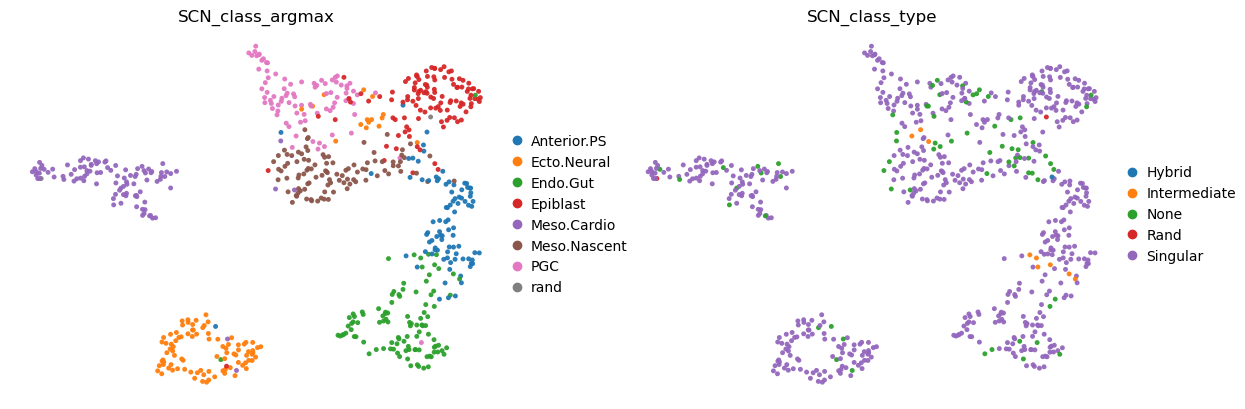

In [48]:
def_npcs = 30
def_nneigh = 10
sc.pp.neighbors(adtest2, n_neighbors = def_nneigh,  n_pcs = def_npcs)
sc.tl.umap(adtest2)
sc.pl.umap(adtest2, color=['SCN_class_argmax', 'SCN_class_type'], size=50, alpha=.95,frameon=False)